In [17]:
# Adapted from: https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl
# the Monte Carlo Exploring-Starts method to find the optimal policy
import numpy as np
import matplotlib.pyplot as plt
from helper import *
from helper.gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

## Initialisation des reward

In [18]:
# rewards:
# ---------------------------
# -0.90|-0.90|-0.90| 1.00|
# ---------------------------
# -0.90| 0.00|-0.90|-1.00|
# ---------------------------
# -0.90|-0.90|-0.90|-0.90|


Comme on peut le voir, le personnage sera initialisé en case [1,1] et devra finir sur la case en haut à droite. Juste en dessous de cette case figure un piège. Nous allons voir comment trouver une policy optimale en utilisant les méthodes de monte Carlo

In [19]:
grid = negative_grid(step_cost=-0.9)
# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|


# Définition du jeu

In [20]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  # each triple s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  seen_states.add(grid.current_state())
  num_steps = 0
  while True:
    r = grid.move(a)
    num_steps += 1
    s = grid.current_state()

    if s in seen_states:
      # we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      reward = -10. / num_steps
      states_actions_rewards.append((s, None, reward))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [21]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

### Initialisation d'une policy aléatoire:

In [22]:
# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS) #Initialisez la policy en affectant une action aléaoire : ALL_POSSIBLE_ACTIONS

# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  L  |  D  |  D  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  L  |  D  |  U  |  R  |


Voici la liste des actions disponibles pour tous les states : 

In [23]:
grid.actions

{(0, 0): ('D', 'R'),
 (0, 1): ('L', 'R'),
 (0, 2): ('L', 'D', 'R'),
 (1, 0): ('U', 'D'),
 (1, 2): ('U', 'D', 'R'),
 (2, 0): ('U', 'R'),
 (2, 1): ('L', 'R'),
 (2, 2): ('L', 'R', 'U'),
 (2, 3): ('L', 'U')}

### Initialisation de Q(S,A) avec la valeure 0

In [24]:
# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
  if s in grid.actions: # not a terminal state
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0
      returns[(s,a)] = []
  else:
    # terminal state or state we can't otherwise get to
    pass

# initial Q values for all states in grid
Q

{(0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}

# Monte Carlo

Comme nous avons vu en cours, nous allons parcourir les chemins de manière aléatoire, puis nous nous souviendrons des chemins parcourus et des réponses obtenues pour mettre à jour notre policy

In [25]:
# Voici la logique à implémenter :

# pour chaque épisode:
#     jouer au jeu avec la policy actuelle et récupérer la liste des coups joués
#     Pour toutes les actions jouées:
#         si le couple (state,action) n' a pas été déjà vu:
#             ajouter au dict "returns" la récompense obtenue du run joué précédemment
#             Affecter à Q(s,a) la moyenne des récompenses obtenues par le couple (s,a)
    
#     Mettre à jour la policy 

In [28]:
# repeat until convergence

def monte_carlo(nb_episode, policy, grid, returns, Q):
    deltas = []
    for t in range(nb_episode):
      # generate an episode using pi
      biggest_change = 0
      states_actions_returns = play_game(grid, policy)
      seen_state_action_pairs = set()
      for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        sa = (s, a)
        if sa not in seen_state_action_pairs:
          old_q = Q[s][a]
          #AJOUTER LA RECOMPENSE à "returns"
          returns[sa].append(G)
          Q[s][a] = np.mean(returns[sa])
          biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
          seen_state_action_pairs.add(sa)
      deltas.append(biggest_change)

      # update policy : on-policy
      for s in policy.keys():
        policy[s] = max_dict(Q[s])[0]
    return policy, deltas

# Lancez des runs en variant le nombre d'épisode.

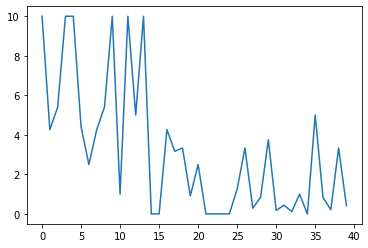

final policy:
---------------------------
  U  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  R  |  R  |  R  |  U  |


In [29]:

nb_episode = 40
policy,deltas = monte_carlo(nb_episode, policy, grid, returns, Q)
plt.plot(deltas)
plt.show()

print("final policy:")
print_policy(policy, grid)

## Affichons maintenant la value finale obtenue : 

In [30]:
# find V
V = {}
for s, Qs in Q.items():
  V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)

final values:
---------------------------
-3.75| 0.00| 1.00| 0.00|
---------------------------
-4.15| 0.00|-1.00| 0.00|
---------------------------
-3.96|-2.76|-2.38|-1.00|


In [31]:
Q

{(0, 1): {'U': -8.75, 'D': -5.0, 'L': -5.0, 'R': 0.0},
 (1, 2): {'U': -3.15, 'D': -4.0725, 'L': -10.0, 'R': -1.0},
 (2, 1): {'U': -10.0, 'D': -10.0, 'L': -5.1723, 'R': -2.7589999999999995},
 (0, 2): {'U': -6.25, 'D': -4.2615, 'L': -5.4, 'R': 1.0},
 (2, 2): {'U': -3.735, 'D': -10.0, 'L': -3.15, 'R': -2.3750000000000004},
 (1, 0): {'U': -4.1499999999999995,
  'D': -4.217066666666667,
  'L': -10.0,
  'R': -10.0},
 (0, 0): {'U': -3.75, 'D': -4.34304, 'L': -6.666666666666667, 'R': -5.4},
 (2, 0): {'U': -4.515,
  'D': -4.166666666666667,
  'L': -5.0,
  'R': -3.9609166666666664},
 (2, 3): {'U': -1.0, 'D': -2.5, 'L': -4.2615, 'R': -3.3333333333333335}}

### Implémentez maintenant la logique Epsilon greedy !

Pour ce faire vous pouvez vous aider de ce notebook en identifiant les modifications de code à effectuer : https://github.com/omerbsezer/Reinforcement_learning_tutorial_with_demo/blob/master/monte_carlo_epsilon_greedy_demo.ipynb